In [ ]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
from collections import defaultdict


In [ ]:
df_raw = pd.read_excel("output/resampled_df_10_min.xlsx", index_col=[0])

In [ ]:
start_date = pd.to_datetime(f"2023-01-01 00:00:00")
end_date = pd.to_datetime(f"2023-05-01 23:50:00")
training_window_size = 7
horizon_size = 7
model_features = ["day", "weekday", "hour", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

baseline_performance = defaultdict(dict)

In [ ]:
df = df_raw[df_raw["time"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)

In [ ]:
df["day"] = df["time"].dt.day
df["weekday"] = df["time"].dt.dayofweek
df["hour"] = df["time"].dt.hour
df["window_block"] = ((df['time'].dt.minute * 60 + df['time'].dt.second) // 600).astype(int)


In [ ]:
df.head(10)

In [ ]:
train_start_date = start_date
train_end_date = train_start_date + pd.Timedelta(days=training_window_size-1, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=horizon_size-1, hours=23, minutes=50)

train_mask = df["time"].between(train_start_date, train_end_date)
test_mask = df["time"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

In [ ]:
training_data = df.loc[train_mask]
testing_data = df.loc[test_mask]
most_common_locations = training_data.groupby(model_features)['location'].apply(lambda x: x.value_counts().idxmax()).reset_index()

In [ ]:
result_df = testing_data.merge(most_common_locations, how="left", left_on=model_features, right_on=model_features)

features_to_use = model_features[1:]
while result_df['location_y'].isna().sum() > 0:
    print('nan > 0, now trying with features: ', features_to_use)
    most_common_locations = training_data[["location"] + features_to_use].groupby(features_to_use)['location'].apply(lambda x: x.value_counts().idxmax()).reset_index()
    result_df = testing_data.merge(most_common_locations, how="left", left_on=features_to_use, right_on=features_to_use)
    features_to_use = features_to_use[1:]  # Remove the first element to exclude it from the next merge

predictions = result_df.location_y.values.tolist()



In [ ]:
for d in range(horizon_size):
    # Then, evaluate the baseline's predictions and store acc in self.baseline_performance
    this_day_predictions = predictions[d*144:(d+1)*144]
    this_day_actual_values = y_test[d*144:(d+1)*144]
    acc = accuracy_score(this_day_actual_values, this_day_predictions)
    print(f"Acc of baseline: {acc}")

In [15]:
import pickle

with open(f"output/model_performances.pkl", 'rb') as f:
    scores = pickle.load(f)

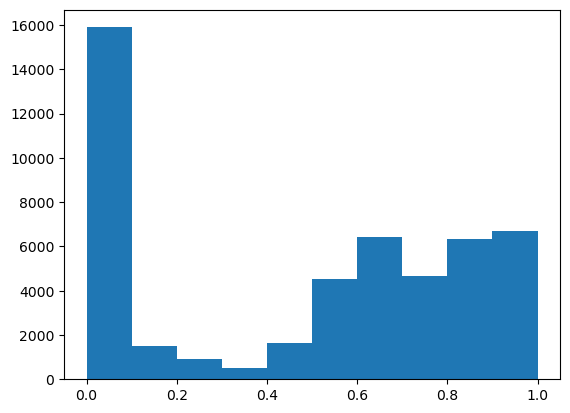

In [35]:
import matplotlib.pyplot as plt
import itertools

for k, v in scores.items():
    # key (k) is "number of training days"
    days = k.split('_')[-1]
    if days == "1":
        sub = scores[k]
        data = []
        for x, y in sub.items():
            # key (x) is number of days into the future 
            data.append(y)

        plt.hist(list(itertools.chain(*data)))
        plt.title(f"Training days: {days}")
        plt.xlabel("Accuracy value")
        plt.ylabel("Count")
        plt.show()